## Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
#import scikit-learn as sci
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
results_file = 'C:/Users/Schlumi/Desktop/IIIBiophysik21-22/Organoids/data/write/pbmc3k.h5ad'  # the file that will store the analysis results

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 pynndescent==0.5.5


In [3]:
    #Read in the count matrix into an AnnData object, which holds many slots for annotations and different 
    #representations of the data.

adata = sc.read_10x_mtx(
   'C:/Users/Schlumi/Desktop/IIIBiophysik21-22/Organoids/data/sample1_control_day6',  # the directory with the `.mtx` file
   var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
   cache=True)                              # write a cache file for faster subsequent reading
adata.var_names_make_unique()

... reading from cache file cache\C-Users-Schlumi-Desktop-IIIBiophysik21-22-Organoids-data-sample1_control_day6-matrix.h5ad


## Preprocessing the Data

normalizing counts per cell


C:\Users\Schlumi\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:182: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:00)


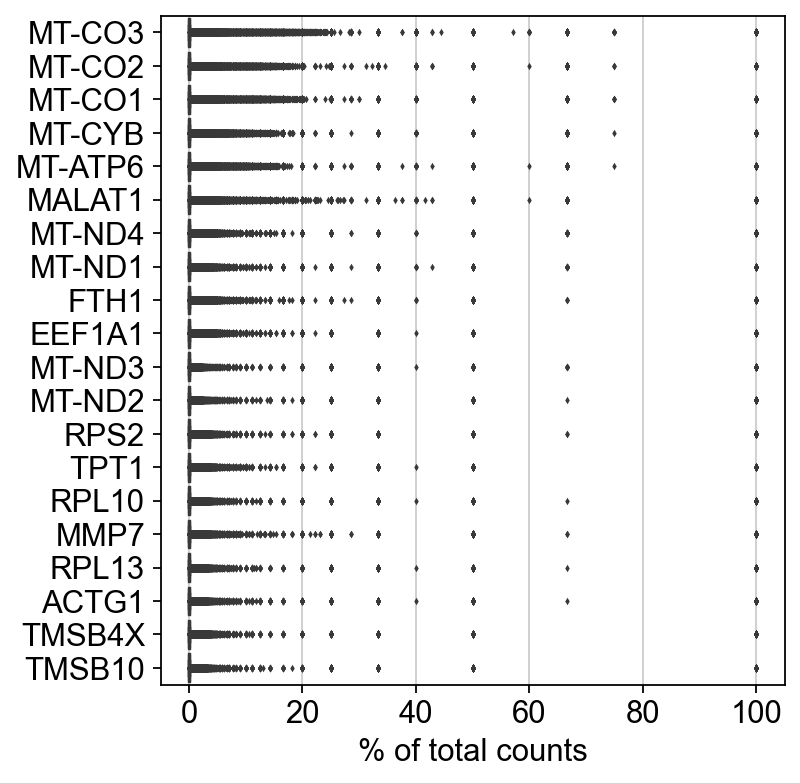

filtered out 6790173 cells that have less than 200 genes expressed
filtered out 13749 genes that are detected in less than 3 cells


... storing 'feature_types' as categorical


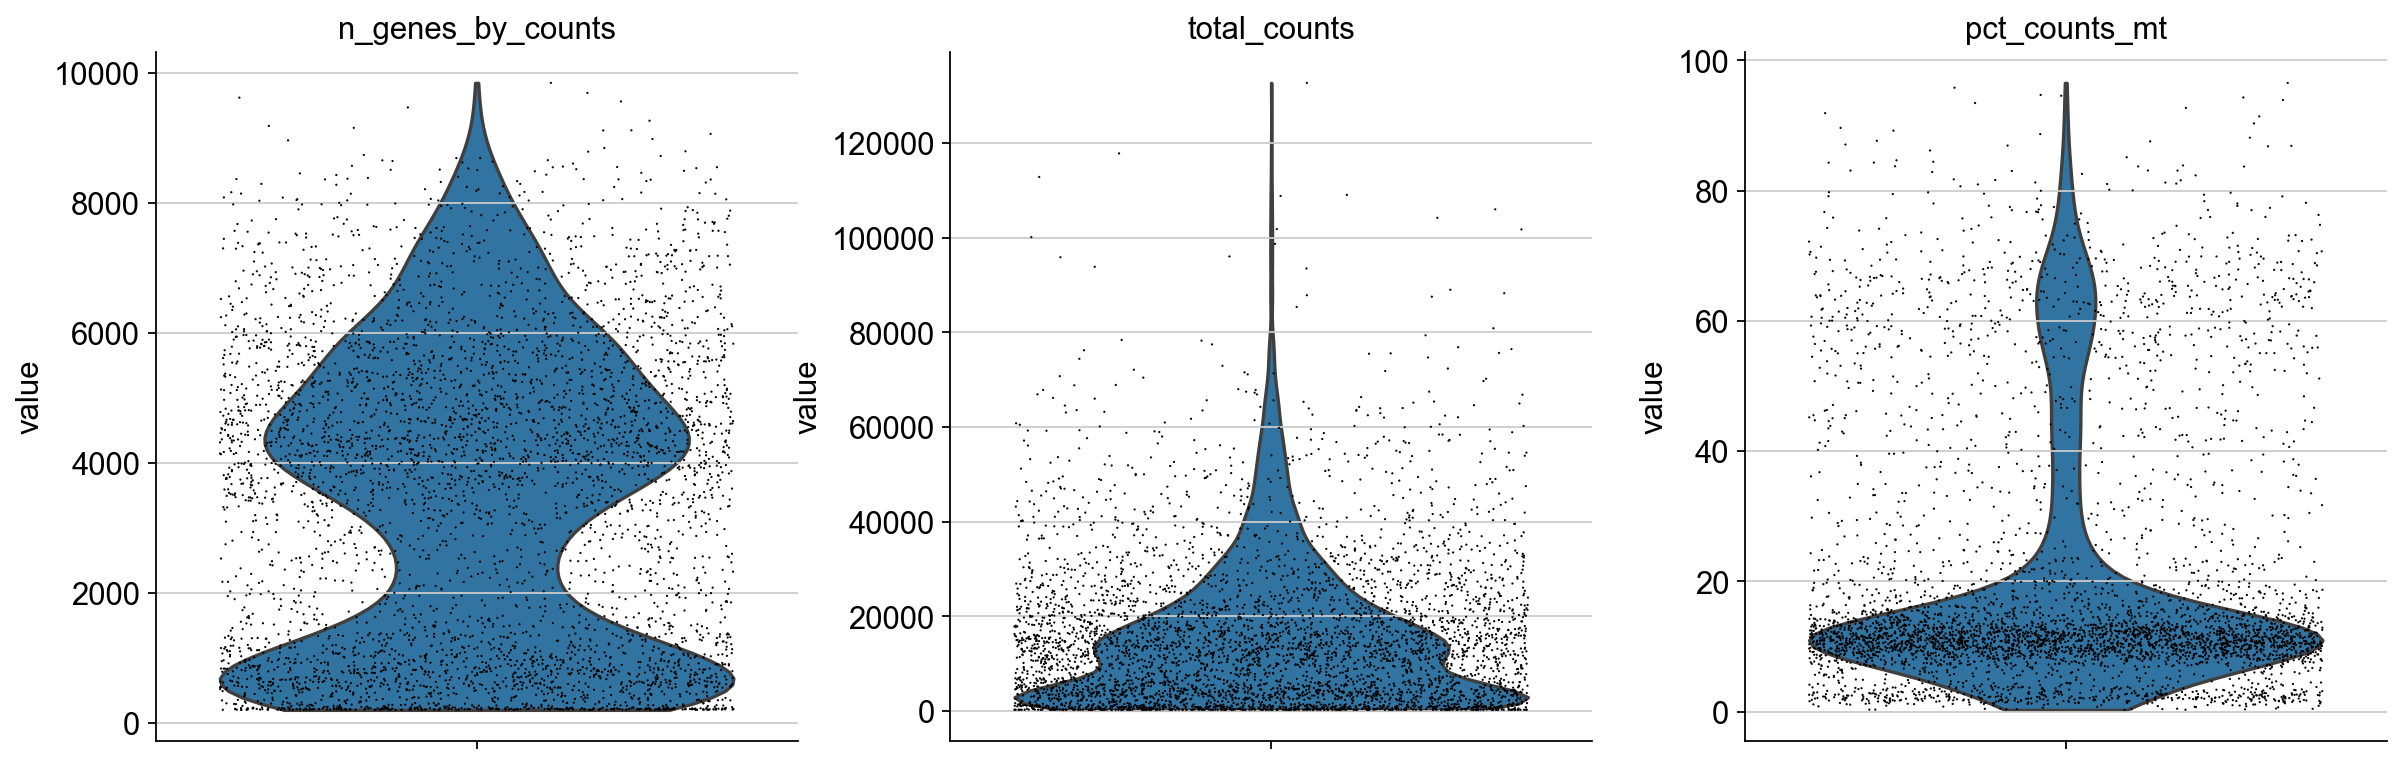

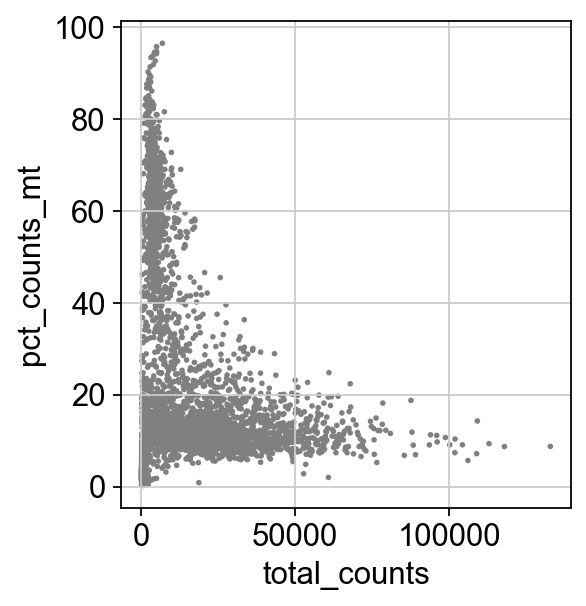

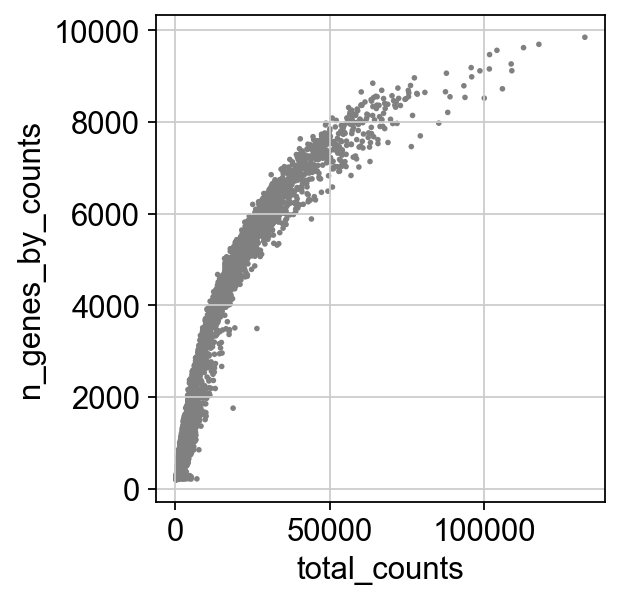

In [4]:
    #Show those genes that yield the highest fraction of counts in each single cell, across all cells.

sc.pl.highest_expr_genes(adata, n_top=20, ) #ln8

    #MITOCHONDRIAL GENES: High proportions are indicative of poor-quality cells, possibly because of loss of cytoplasmic RNA
    #from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less 
    #likely to escape through tears in the cell membrane.

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3) #ln9

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #ln10

    #VIOLIN PlOTS: 1) number of genes expressed in the count matrix, 2) total counts per cell, 
    #3) percentage of counts in mitochondrial genes

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True) #ln11

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts') #ln12

### Acutually filter the data & remove cells that have too many mitochondrial genes expressed / too many total counts

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
#adata = adata[adata.obs.total_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :] #ln13

normalizing counts per cell
    finished (0:00:00)


C:\Users\Schlumi\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


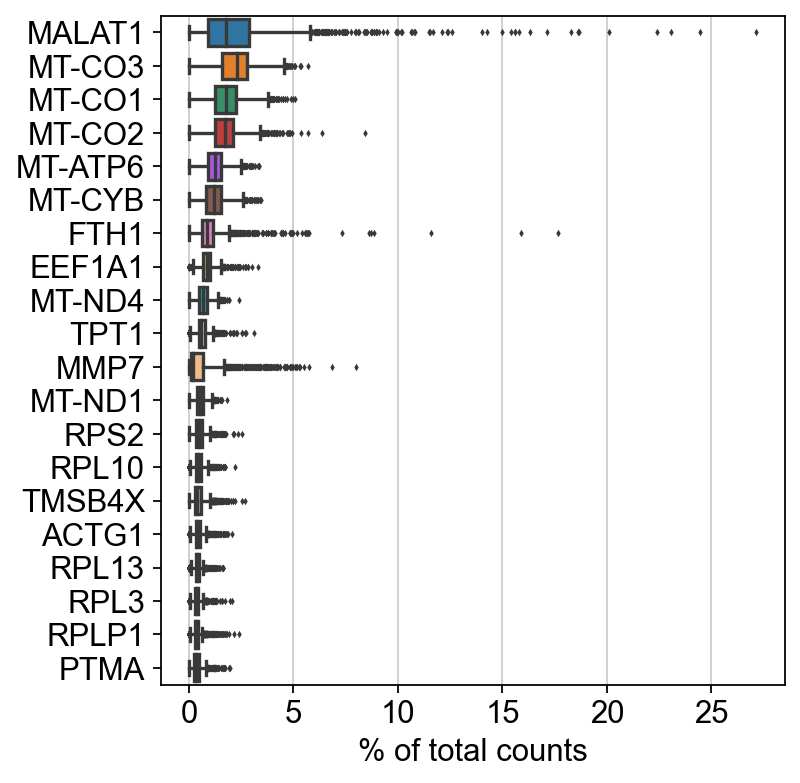

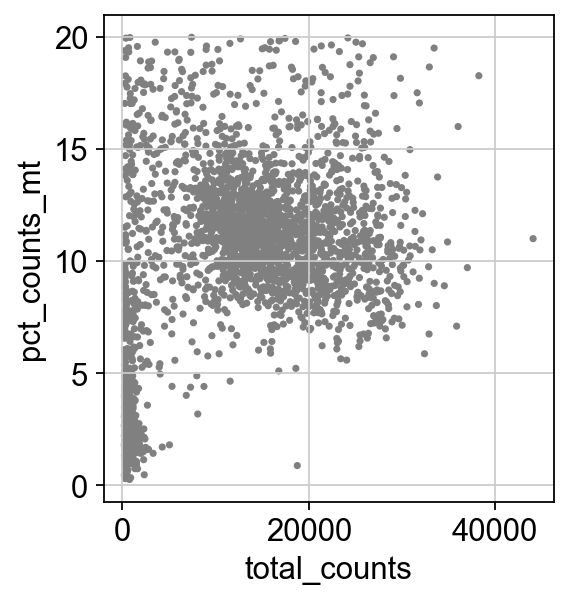

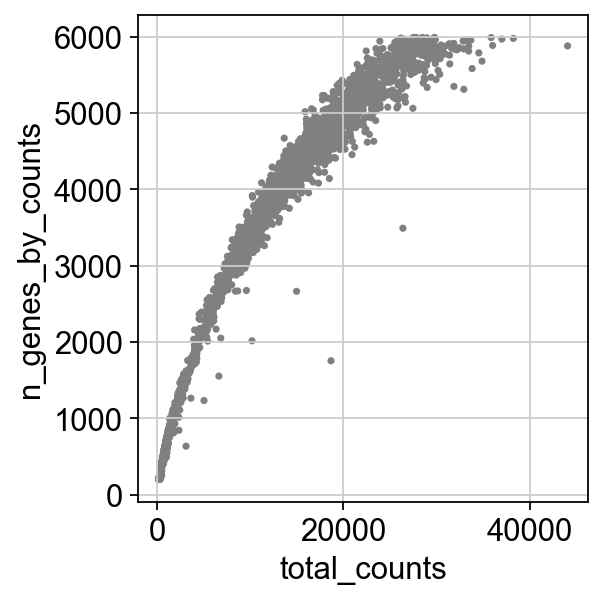

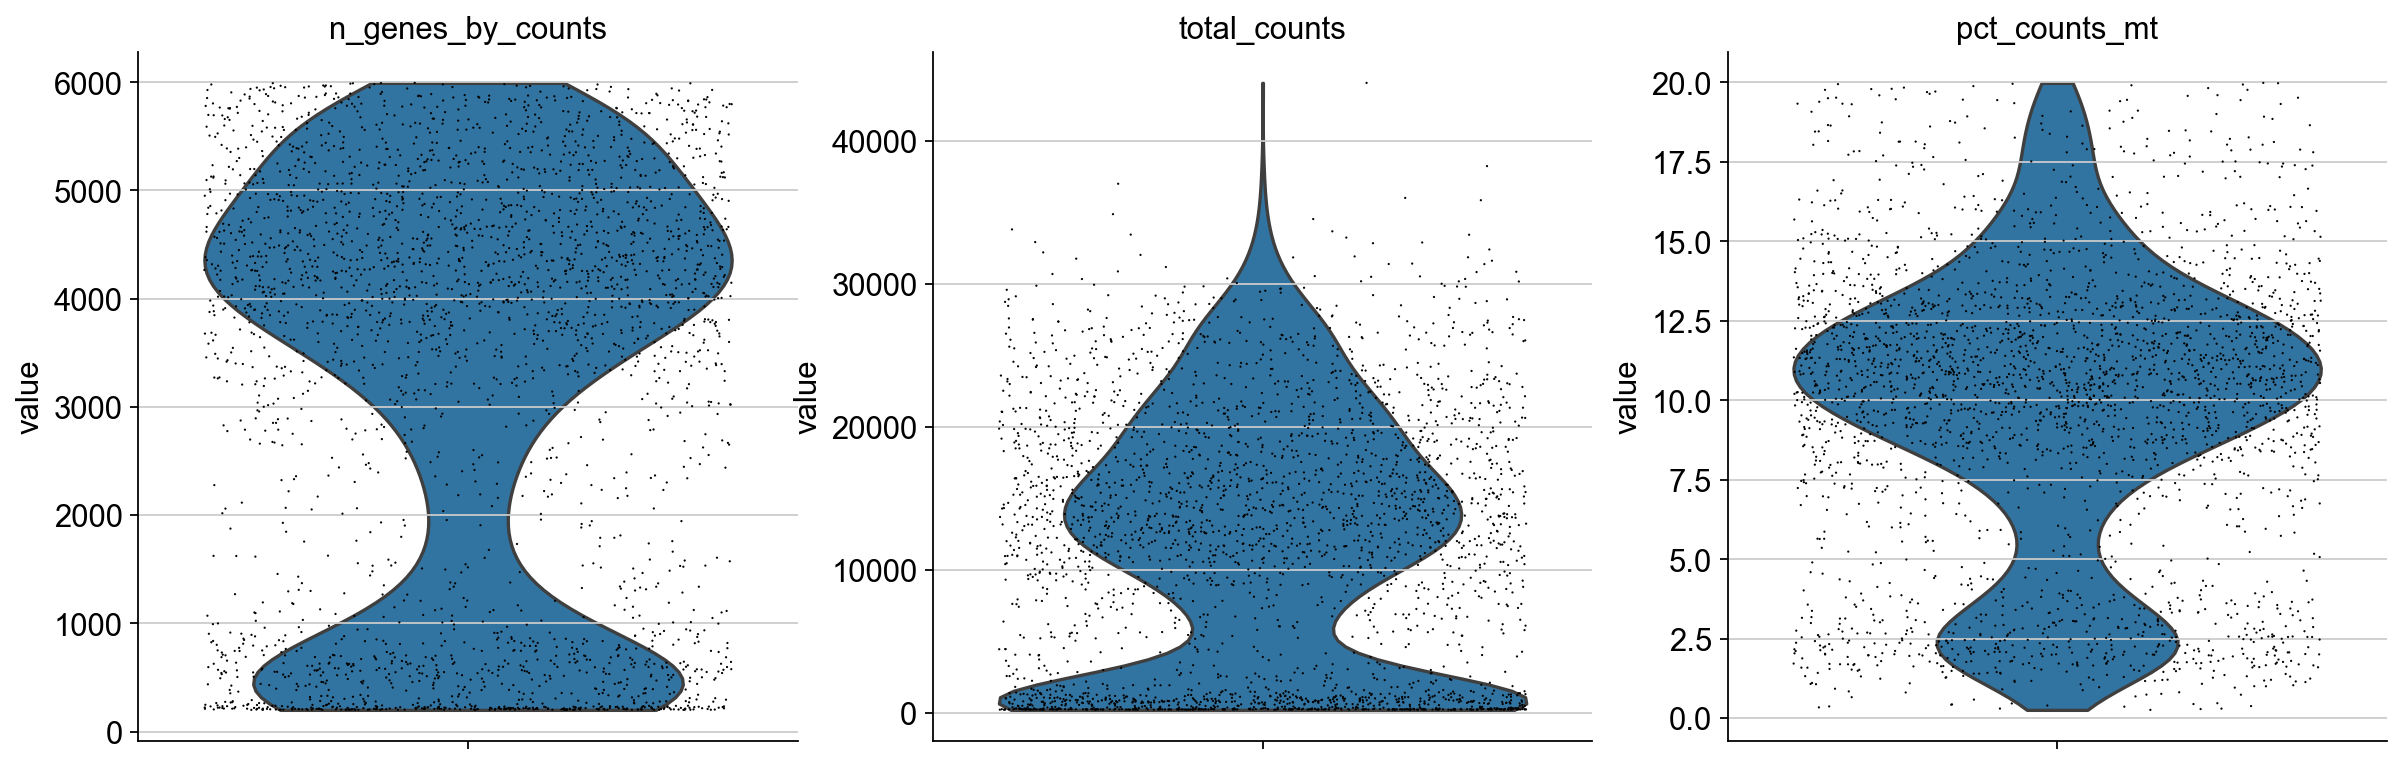

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, ) 

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts') #ln12

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [7]:
    #Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, 
    #so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4) #ln14

normalizing counts per cell
    finished (0:00:00)


In [8]:
    #Logarithmize the data:
sc.pp.log1p(adata) #ln15

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


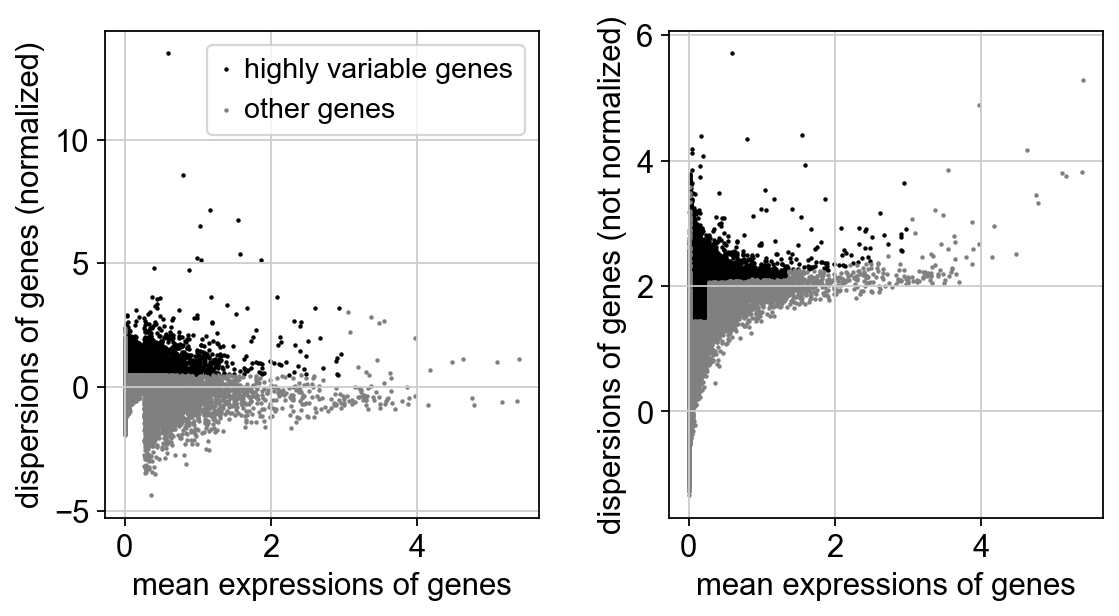

In [9]:
    #Indentify highly-variable genes:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #ln16
sc.pl.highly_variable_genes(adata) #ln17

In [10]:
    #Freeze state of the AnnData object:
adata.raw = adata #ln18

In [11]:
adata = adata[:, adata.var.highly_variable] #19

In [12]:
    #Reress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit
    #variance:
#sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt']) #20

In [13]:
    #Scale each gene to unit variance. Clip values exceeding standard deviation 10:
sc.pp.scale(adata, max_value=10) #ln21

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


C:\Users\Schlumi\anaconda3\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Principal Component Analysis (PCA)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)


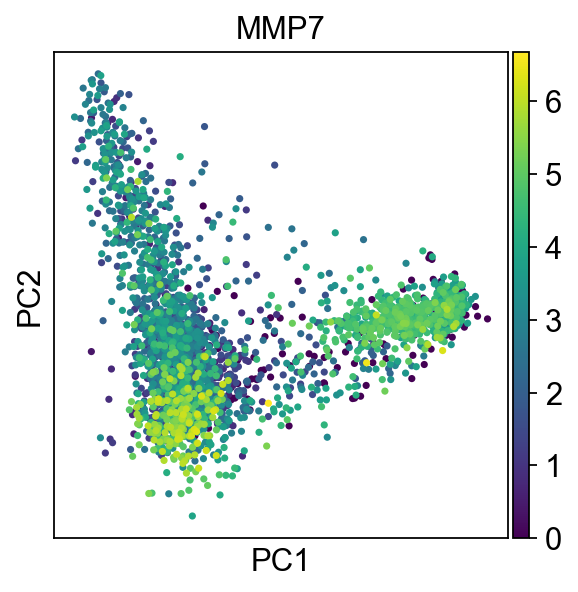

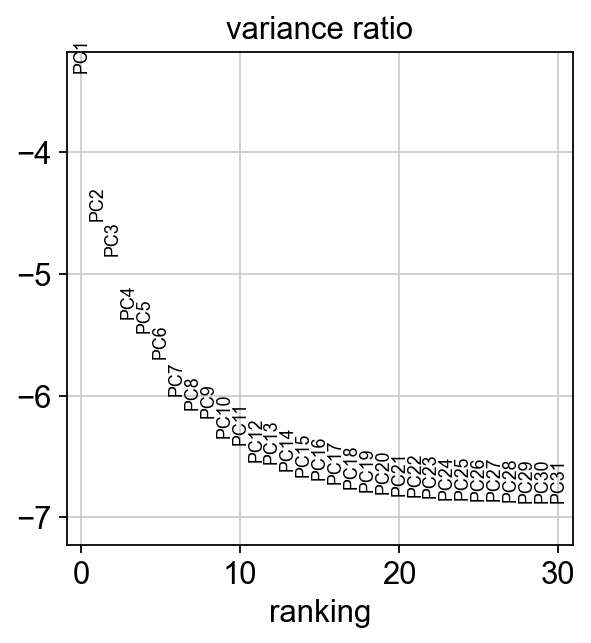

In [14]:
    #Reduce the dimensionality of the data by running PCA: reveals the main axes of variation and denoises the data.

sc.tl.pca(adata, svd_solver='arpack') #ln22

sc.pl.pca(adata, color='MMP7') #ln23

    #Contribution of single PCs to the total variance of the data. 
sc.pl.pca_variance_ratio(adata, log=True) #ln24

In [15]:
#adata.write(results_file) #ln25

#adata #ln26

## Computing the neighborhood graph

In [36]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8) #ln27

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished (0:00:00)


## Embedding the neighborhood graph

In [37]:
#sc.tl.paga(adata)
#sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
#sc.tl.umap(adata, init_pos='paga')

In [38]:
sc.tl.umap(adata) #ln28

computing UMAP
    finished (0:00:07)


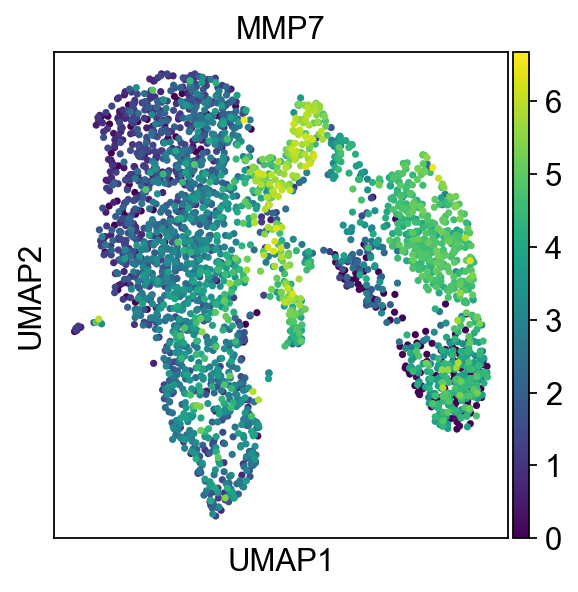

In [39]:
sc.pl.umap(adata, color=['MMP7']) #ln29 #'MMP7', 'RPS2', 'PTMA'

## Clustering the neighborhood graph

In [40]:
sc.tl.leiden(adata) #ln31

running Leiden clustering
    finished (0:00:00)


In [41]:
print(adata.var_names)

Index(['LINC00115', 'AL645608.8', 'HES4', 'ISG15', 'RNF223', 'C1orf159',
       'AL390719.2', 'TNFRSF18', 'B3GALT6', 'UBE2J2',
       ...
       'AP001059.2', 'C21orf2', 'TRPM2', 'LRRC3', 'ITGB2-AS1', 'ADARB1',
       'POFUT2', 'COL6A1', 'YBEY', 'DIP2A'],
      dtype='object', length=6428)


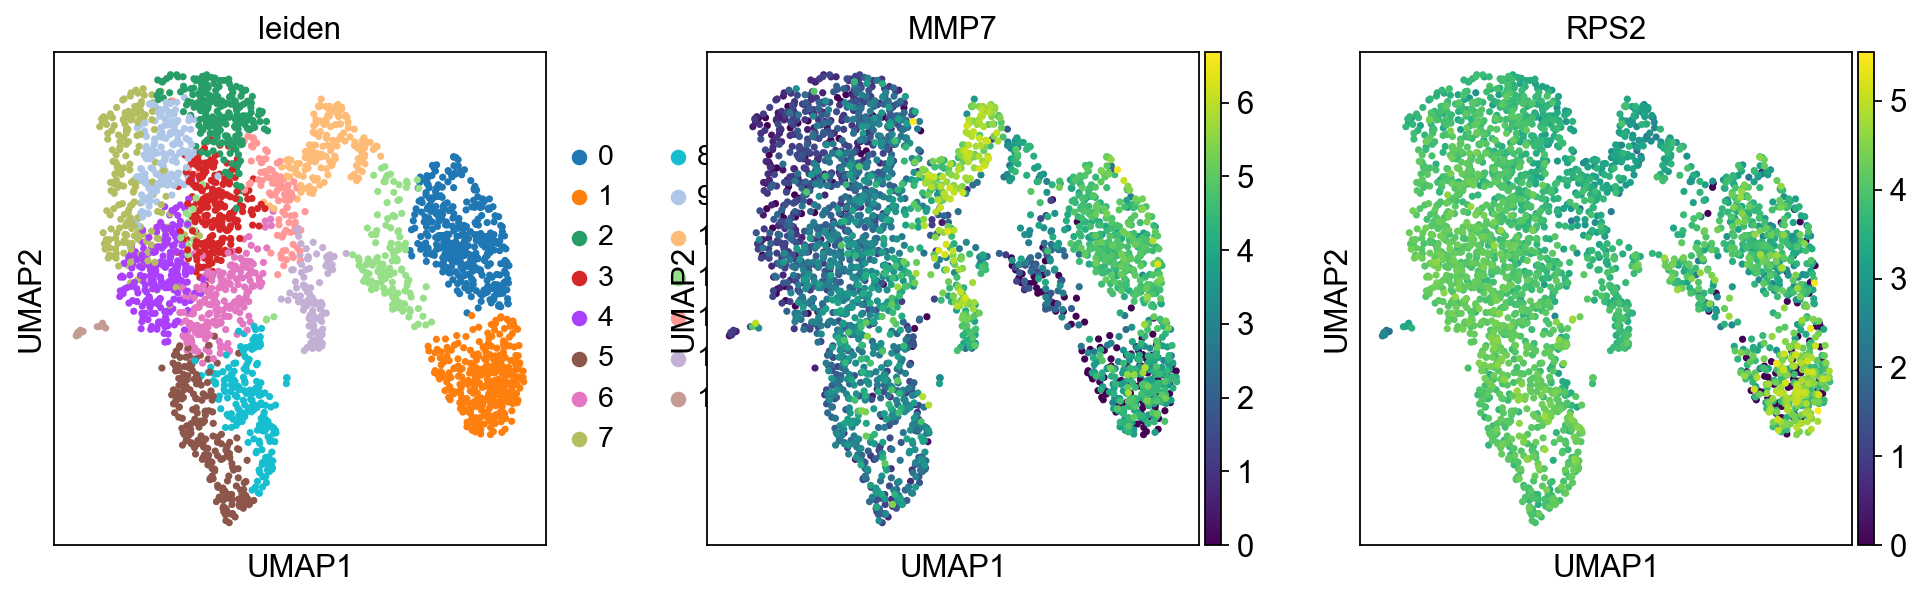

In [42]:
sc.pl.umap(adata, color=['leiden', 'MMP7', 'RPS2']) #ln32

In [43]:
#adata.write(results_file) #ln33

## Finding marker genes

ranking genes
    finished (0:00:03)


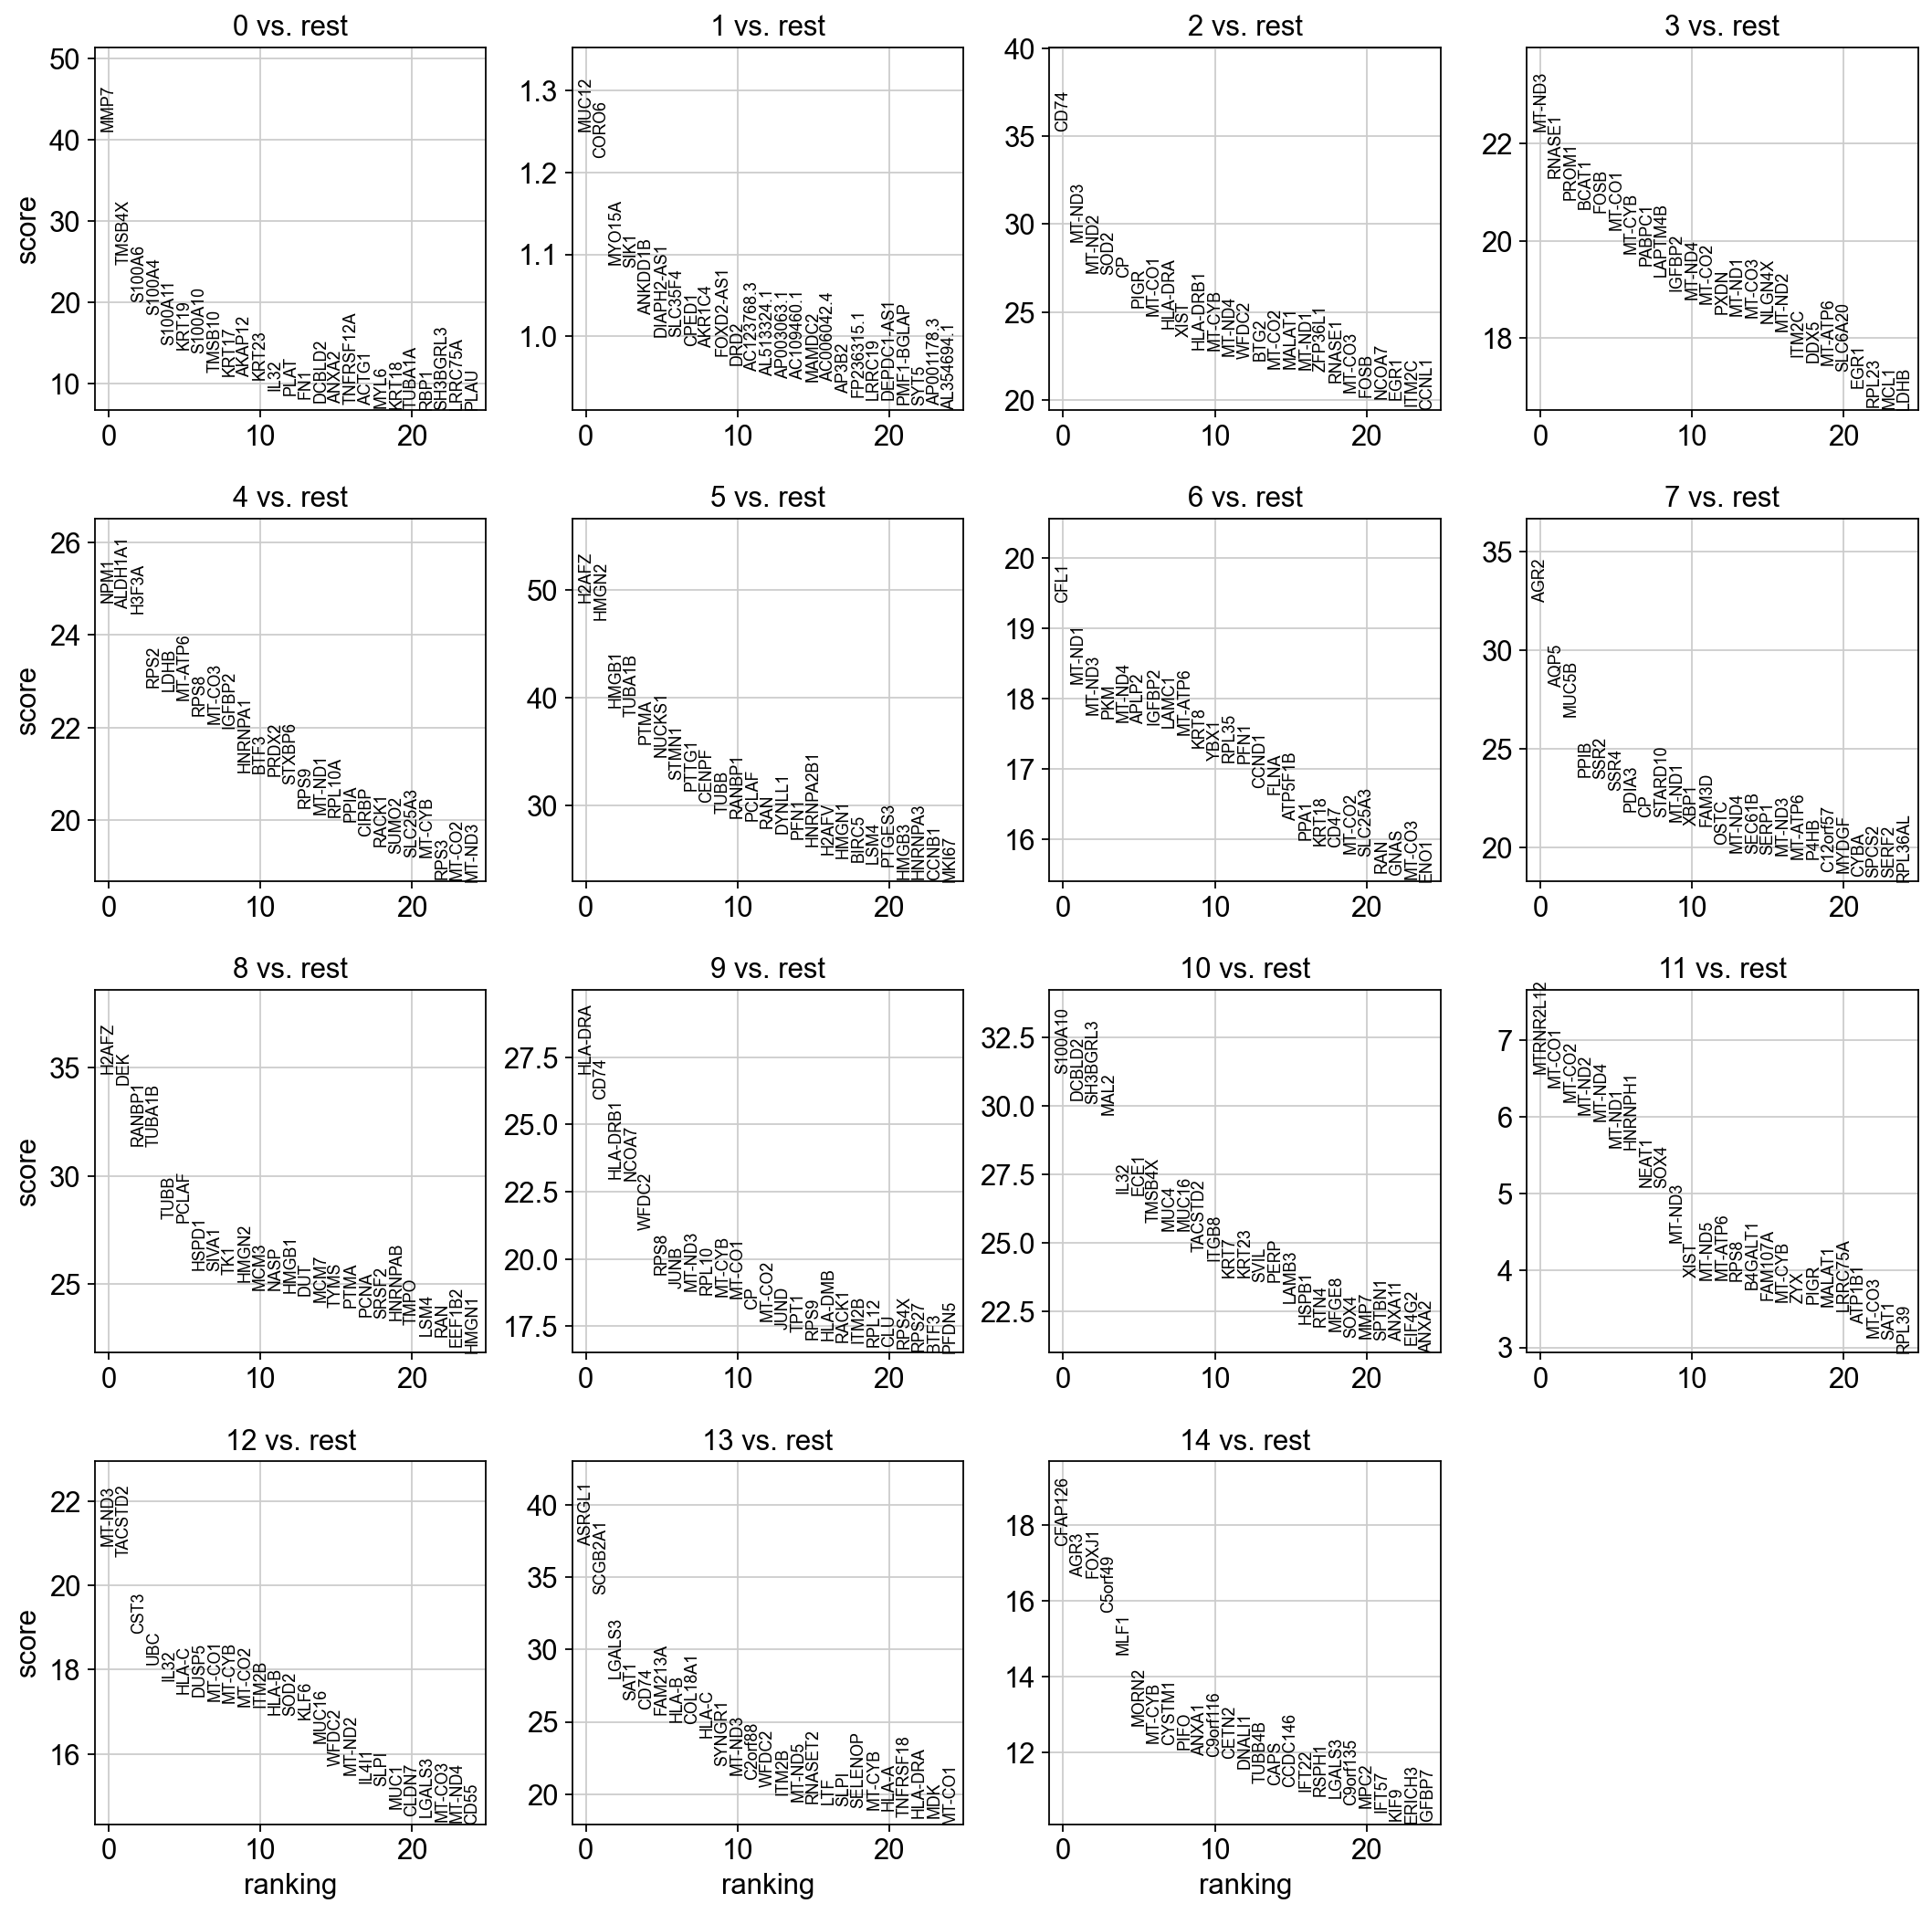

ranking genes
    finished (0:00:13)


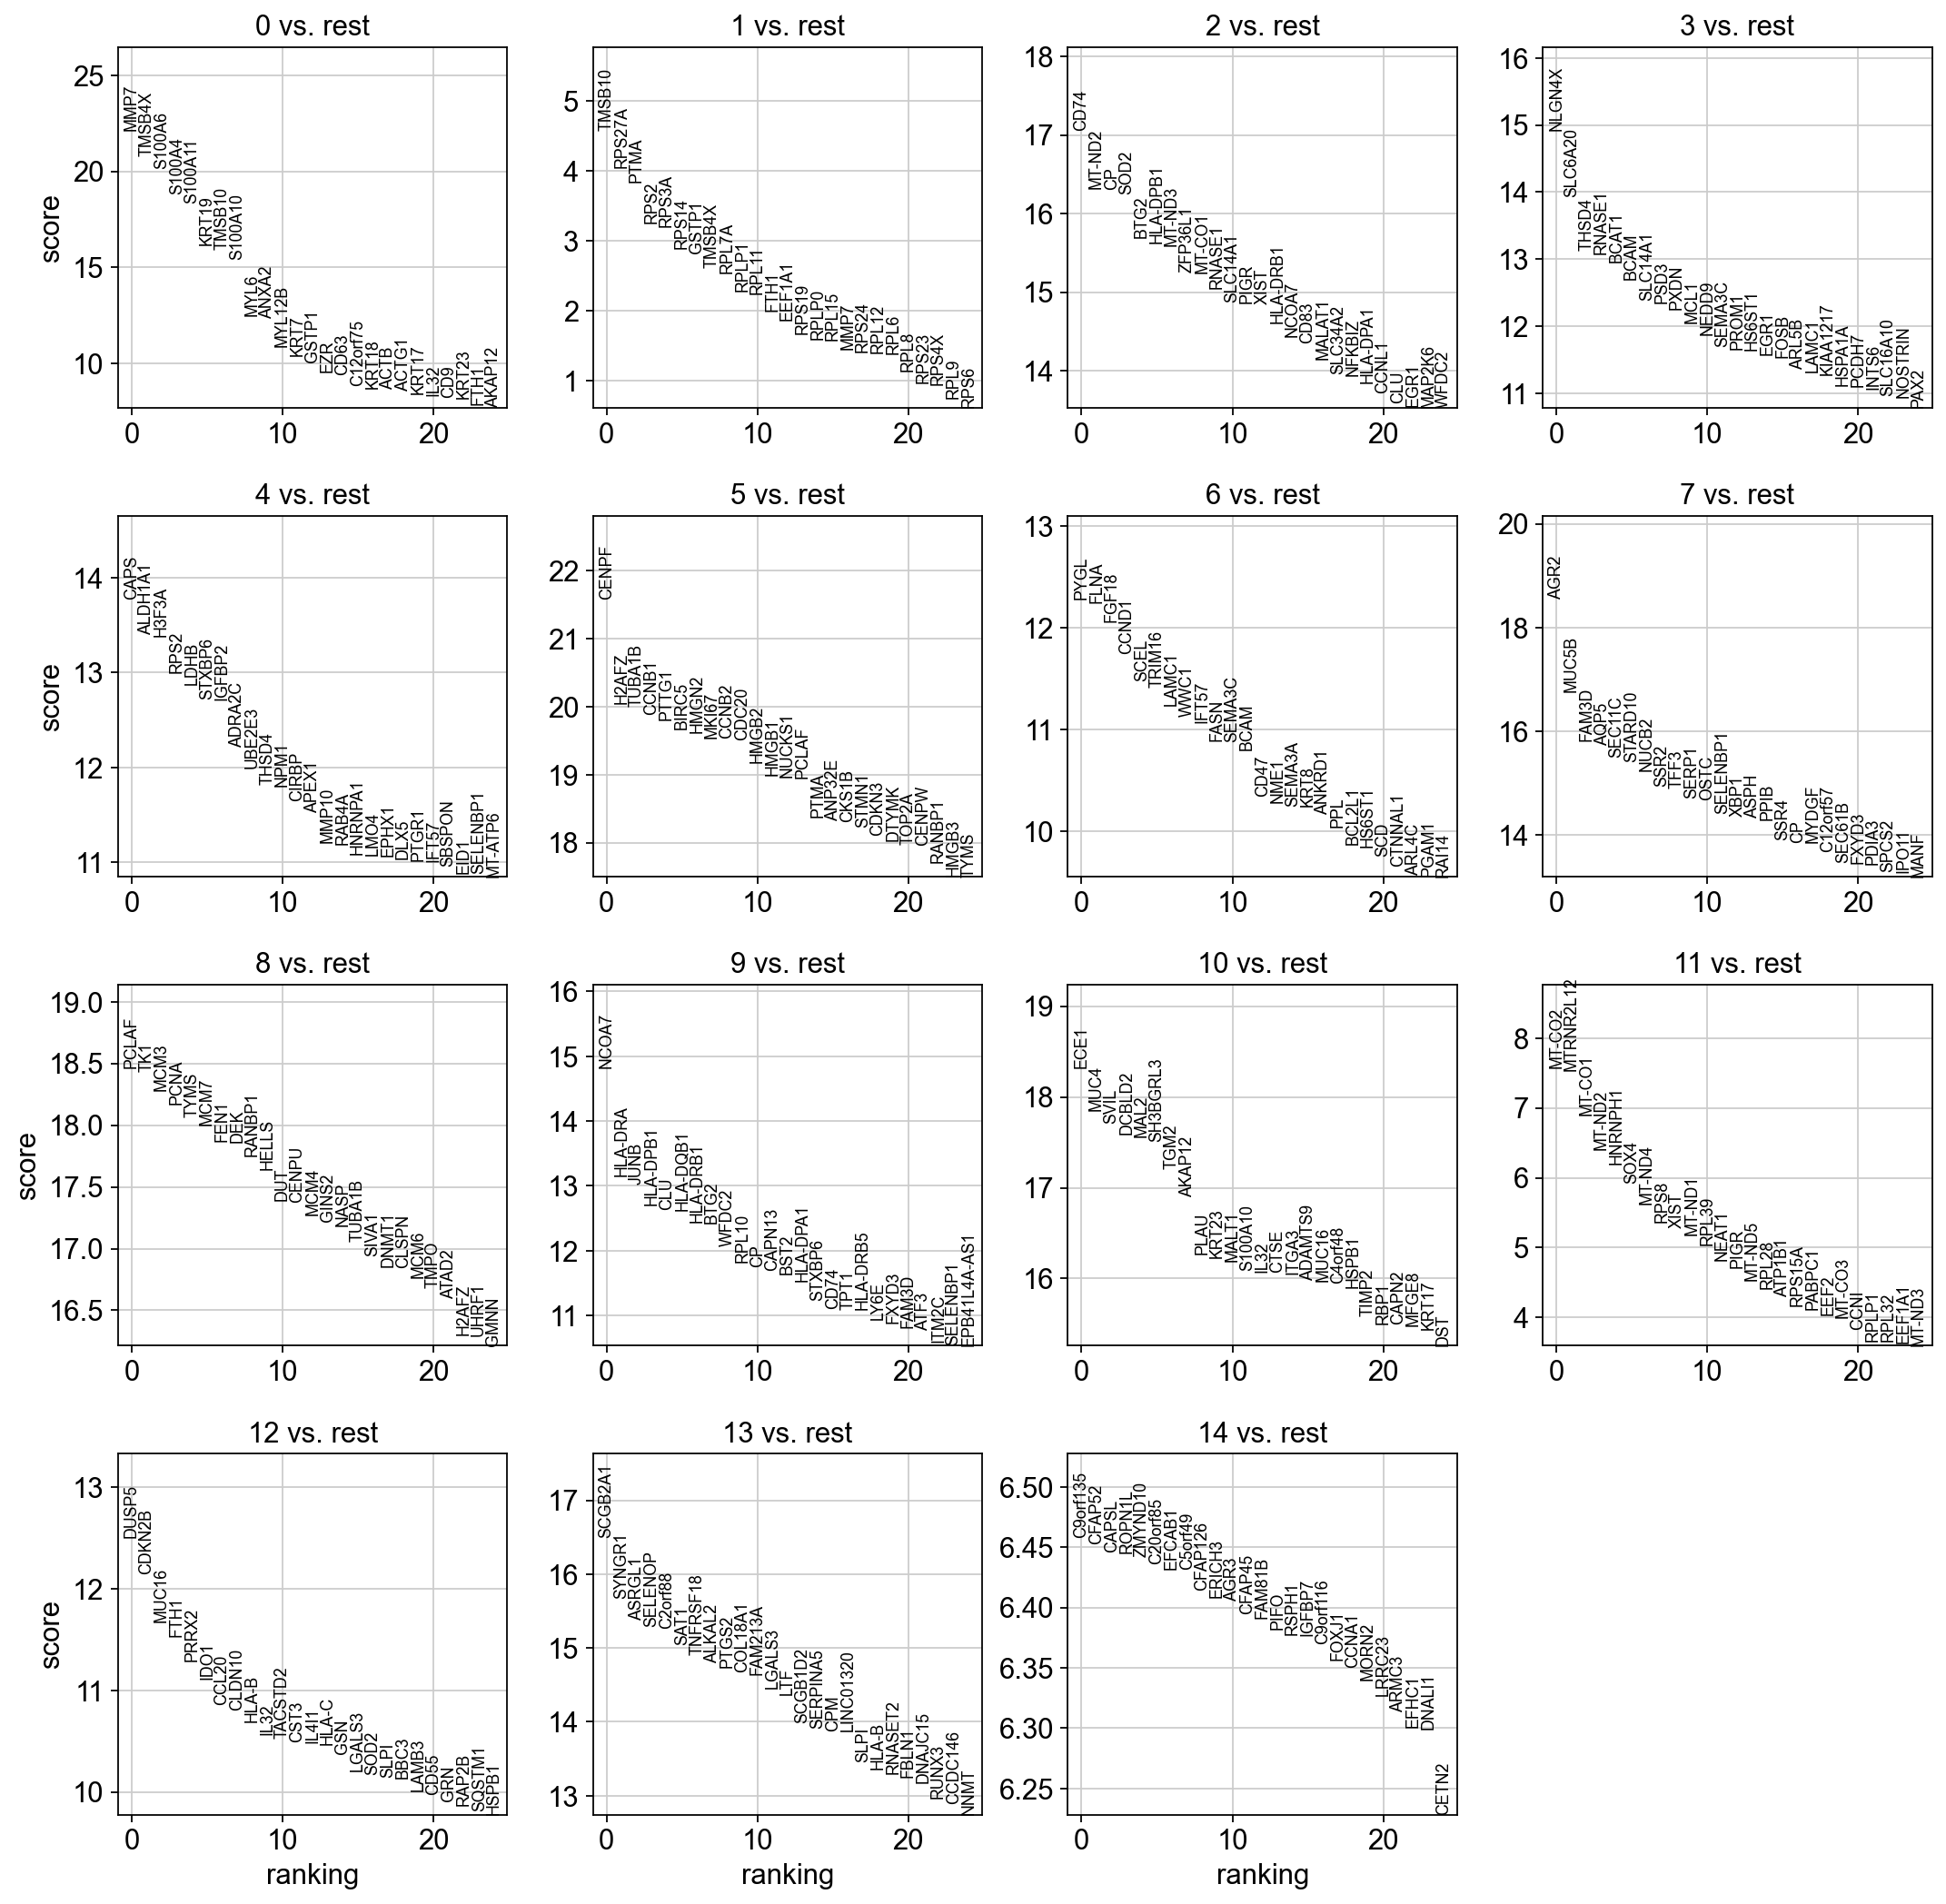

OSError: Unable to create file (unable to open file: name = 'C:\Users\Schlumi\Desktop\IIIBiophysik21-22\Organoids\data\write\pbmc3k.h5ad', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 302)

In [44]:
    #t-test: compute a ranking for the highly differential genes in each cluster:

sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln34

sc.settings.verbosity = 2  # reduce the verbosity #ln35

    #result of a Wilcoxon rank-sum test:

sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln36

adata.write(results_file) #ln37

    #rank genes using logistic regression:

sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False) #ln38

In [ ]:
#marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
#                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
#                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP'] #ln39
#
#genes_list = ['NCR3', 'MMP1', 'MMP3', 'MMP10', 'Wnt5', 'Wnt7a', 'MMP26', 'TFF3', 'Hoxa10', 'Hoxa11', 'Conenxin-37', 
#              'Hoxb7', 'sFRP', 'MMP11', 'tPA', 'PLAT', 'ADAM12', 'IGF', 'TGF', 'FGF1', 'HGF', 'FGFR3']
#
#top_20_Organoid_Control = ['FTH1', 'MALAT1', 'EEF1A1', 'MT-CO3', 'TPT1', 'MT-CO1', 'RPS2', 'TMSB4X', 'MT-CO2', 
#          'RPL10', 'MT-ATP6', 'MMP7', 'RPL13', 'PTMA', 'MT-CYB', 'ACTG1', 'RPL3', 'RPLP1', 
#          'RPS12', 'RPS18']
#
#genes_epi = ['PLAU', 'MMP7', 'THBS1', 'CADM1', 'NPAS3', 'ATP1A1', 'ANK3', 'ALPL', 'TRAK1', 
#         'SCGB1D2', 'MT1F', 'MT1X', 'MT1E', 'MT1G', 'CXCL14', 'MAOA', 'DPP4', 'NUPR1', 'GPX3'
#        'PAEP']
#
#genes_str = ['STC1', 'NFATC2', 'BMP2', 'PMAIP1', 'MMP11', 'SFRP1', 'WNT5A', 'ZFYVE21', 'CILP', 
#             'SLF2', 'MATN2', 'S100A4', 'DKK1', 'CRYAB', 'FOXO1', 'IL15', 'FGF7', 'LMCD1']
#
#genes_early = ['MMP26', 'TFF3', 'Hoxa10', 'Hoxa11', 'Conenxin-37', 'Hoxb7', 'sFRP', 'WIF', 'TGFB2', 'CCL18', 'PGR', 'ESR1'] 
#
#genes_late = ['SOX4', 'ADAMTS5', 'GNG4', 'Integrina2', 'EBAF', 'MMP7', 'proMMP3', 'EDNRB', 'MMP10', 'MMP', 'PLAU', 'PLAT', 
#              'ADAM', 'PAEP', 'CIQTNF6'] 
#
#important_genes = []

In [45]:
    #reload the object that has been saved with the Wilcoxon Rank-Sum test result:

#adata = sc.read(results_file) #ln40

In [47]:
    #show the 10 top ranked genes per cluster in a dataframe:

pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10) #ln41

0       1         2        3        4       5       6        7  \
0     MMP7  TMSB10      CD74   NLGN4X     CAPS   CENPF    PYGL     AGR2   
1   TMSB4X  RPS27A    MT-ND2  SLC6A20  ALDH1A1   H2AFZ    FLNA    MUC5B   
2   S100A6    PTMA        CP    THSD4    H3F3A  TUBA1B   FGF18    FAM3D   
3   S100A4    RPS2      SOD2   RNASE1     RPS2   CCNB1   CCND1     AQP5   
4  S100A11   RPS3A      BTG2    BCAT1     LDHB   PTTG1    SCEL   SEC11C   
5    KRT19   RPS14  HLA-DPB1     BCAM   STXBP6   BIRC5  TRIM16  STARD10   
6   TMSB10   GSTP1    MT-ND3  SLC14A1   IGFBP2   HMGN2   LAMC1    NUCB2   
7  S100A10  TMSB4X   ZFP36L1     PSD3   ADRA2C   MKI67    WWC1     SSR2   
8     MYL6   RPL7A    MT-CO1     PXDN   UBE2E3   CCNB2   IFT57     TFF3   
9    ANXA2   RPLP1    RNASE1     MCL1    THSD4   CDC20    FASN    SERP1   

        8         9        10         11      12        13        14  
0   PCLAF     NCOA7      ECE1     MT-CO2   DUSP5   SCGB2A1  C9orf135  
1     TK1   HLA-DRA      MUC4  MTRNR2L12  CDKN2B    SYNGR1    CFAP52  
2    MCM3      JUNB      SVIL     MT-CO1   MUC16    ASRGL1     CAPSL  
3    PCNA  HLA-DPB1    DCBLD2     MT-ND2    FTH1   SELENOP    ROPN1L  
4    TYMS       CLU      MAL2    HNRNPH1   PRRX2   C2orf88   ZMYND10  
5    MCM7  HLA-DQB1  SH3BGRL3       SOX4    IDO1      SAT1  C20orf85  
6    FEN1  HLA-DRB1      TGM2     MT-ND4   CCL20  TNFRSF18    EFCAB1  
7     DEK      BTG2    AKAP12       RPS8  CLDN10    ALKAL2   C5orf49  
8  RANBP1     WFDC2      PLAU       XIST   HLA-B     PTGS2   CFAP126  
9   HELLS     RPL10     KRT23     MT-ND1    IL32   COL18A1    ERICH3

In [ ]:
    #Get a table with the scores and groups:

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5) #ln42

In [ ]:
    #Compare to a single cluster:

sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20) #ln43

    #more detailed view for a certain group:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
    #reload the objects with the computed differential expression:
#adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
    #If we want to compare a certain gene across groups:
sc.pl.violin(adata, ['MMP7', 'RPS2', 'PTMA'], groupby='leiden')

In [ ]:
    #actually mark/annotate the cell types:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
    #visualize the marker genes:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

## dotplot

In [ ]:
    #quick way to check the expression of genes

sc.pl.dotplot(adata, marker_genes, 'clusters', dendrogram=True)

## matrixplot

In [ ]:
sc.pl.matrixplot(adata, marker_genes, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

# scale and store results in layer
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X

sc.pl.matrixplot(adata, marker_genes, 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

## Heatmaps

In [ ]:
ax = sc.pl.heatmap(adata, marker_genes, groupby='clusters', cmap='viridis', dendrogram=True, swap_axes=True)

sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);